In [12]:
import joblib
import json

import matplotlib.pyplot as plt
import numpy as np
import base64
import cv2
import pywt

In [13]:
__class_name_to_number = {}
__class_number_to_name = {}

path_to_image = r"C:\Users\spark\PycharmProjects\image_face_recognition\data\test_images\test_photo_13.jpg"

__model = None

In [14]:
def w2d(im_array, mode='haar', level=1):
    """
    Функция выделяет черты лица (контрасты)
    :param im_array: картинка прочитаная cv.imread
    :param mode: применяет вейвлетное преобразование в указанном режиме
    :param level: и заданном уровне
    :return:
    """
    #imArray = img
    #Datatype conversions
    #convert to grayscale
    im_array = cv2.cvtColor( im_array,cv2.COLOR_RGB2GRAY )
    #convert to float
    im_array =  np.float32(im_array)
    im_array /= 255
    # compute coefficients
    coefficients = pywt.wavedec2(im_array, mode, level=level)

    #Process Coefficients
    coefficients_h = list(coefficients)
    coefficients_h[0] *= 0

    # reconstruction
    im_array_h=pywt.waverec2(coefficients_h, mode)
    im_array_h *= 255
    im_array_h =  np.uint8(im_array_h)

    return im_array_h

In [15]:
def classify_image(image, file_path=None):
    """

    :param image_base64_data:
    :param file_path:
    :return:
    """
    imgs = get_cropped_image_if_2_eyes(image)

    result = []
    for img in imgs:
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)

        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32 * 32 * 3, 1), scalled_img_har.reshape(32 * 32, 1)))

        len_image_array = 32*32*3 + 32*32

        final = combined_img.reshape(1,len_image_array).astype(float)

        result.append({
            'class': class_number_to_name(__model.predict(final)[0]),
            'class_probability': np.around(__model.predict_proba(final)*100,2).tolist()[0],
            'class_dictionary': __class_name_to_number
        })

    return result

In [16]:
def class_number_to_name(class_num):
    return __class_number_to_name[class_num]

In [17]:
def load_saved_artifacts():
    # print("loading saved artifacts...start")
    global __class_name_to_number
    global __class_number_to_name

    with open(r"C:\Users\spark\PycharmProjects\image_face_recognition\class_dictionary.json", "r") as f:
        __class_name_to_number = json.load(f)
        __class_number_to_name = {v:k for k,v in __class_name_to_number.items()}
        # print("classes...done")

    global __model
    if __model is None:
        with open(r'C:\Users\spark\PycharmProjects\image_face_recognition\image_recognition_svm.pkl', 'rb') as f:
            __model = joblib.load(f)
    #         print("model...done")
    # print("loading saved artifacts...done")

In [18]:
# def get_cv2_image_from_base64_string(b64str):
#     '''
#     credit: https://stackoverflow.com/questions/33754935/read-a-base-64-encoded-image-from-memory-using-opencv-python-library
#     :param uri:
#     :return:
#     '''
#     encoded_data = b64str.split(',')[1]
#     nparr = np.frombuffer(base64.b64decode(encoded_data), np.uint8)
#     img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
#     return img

In [19]:
def get_cropped_image_if_2_eyes(image_path):
    face_cascade = cv2.CascadeClassifier(r'C:\Users\spark\PycharmProjects\image_face_recognition\haars\haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(r'C:\Users\spark\PycharmProjects\image_face_recognition\haars\haarcascade_eye.xml')
    #
    # if image_path:
    #     img = cv2.imread(image_path)
    # else:
    #     img = get_cv2_image_from_base64_string(image_base64_data)

    img = cv2.imread(image_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    cropped_faces = []
    for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                cropped_faces.append(roi_color)
    return cropped_faces

In [20]:
from matplotlib import image as mpimg
import pandas as pd

def print_results(dict_of_results, path):

    img = mpimg.imread(path)

    # Нормализация значений пикселей
    img = img / np.max(img)

    plt.imshow(img, cmap=None)
    plt.axis('off')
    plt.show()

    if dict_of_results:
        probabilities = dict_of_results[0]["class_probability"]
        names = list(dict_of_results[0]["class_dictionary"].keys())
        value_list = {}

        print("Вероятности людей:\n")
        print(f"Программа думает что на фото выше \033[4m{dict_of_results[0]['class']}\033[0m\n\n")

        for number, name in enumerate(names):
            value_list[name] = str(probabilities[number]) + " %"

        # Создание DataFrame из скалярных значений с указанием индекса
        df = pd.DataFrame([value_list], index=[1])

        # Вывод DataFrame
        print(df)
    else:
        print("\nНа фото выше не был идентифицирован человек. (Два глаза)\n")

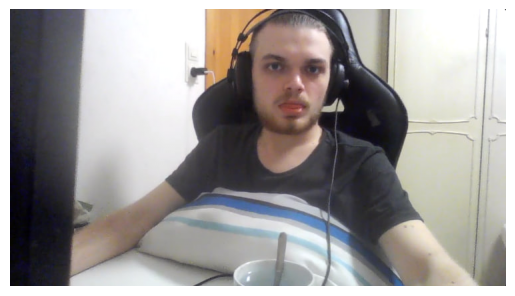

Вероятности людей:

Программа думает что на фото выше mykyta_khambur


  andrey_bond dina_samatova elvira_lukhmenko kyrrylo_chistik liza_dorik  \
1      0.02 %         4.7 %           1.69 %          1.45 %     0.49 %   

  mykyta_khambur  
1        91.65 %  


In [21]:
load_saved_artifacts()

results = classify_image(path_to_image, None)

print_results(results, path_to_image)

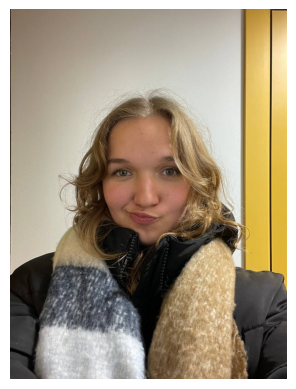

Вероятности людей:

Программа думает что на фото выше dina_samatova


  andrey_bond dina_samatova elvira_lukhmenko kyrrylo_chistik liza_dorik  \
1      2.13 %       42.39 %            0.0 %         12.16 %    39.68 %   

  mykyta_khambur  
1         3.64 %  


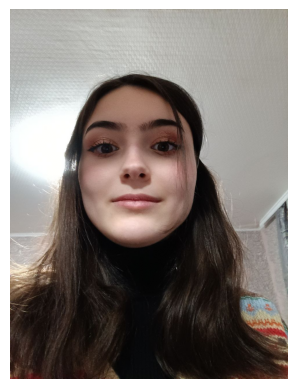

Вероятности людей:

Программа думает что на фото выше elvira_lukhmenko


  andrey_bond dina_samatova elvira_lukhmenko kyrrylo_chistik liza_dorik  \
1     17.85 %       30.43 %          50.17 %          0.04 %     0.86 %   

  mykyta_khambur  
1         0.66 %  


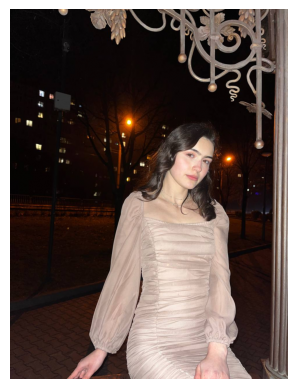


На фото выше не был идентифицирован человек. (Два глаза)



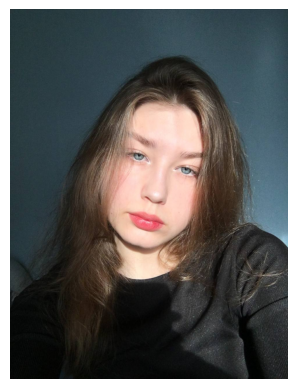

Вероятности людей:

Программа думает что на фото выше liza_dorik


  andrey_bond dina_samatova elvira_lukhmenko kyrrylo_chistik liza_dorik  \
1      1.09 %        0.44 %           1.08 %          2.39 %     94.5 %   

  mykyta_khambur  
1          0.5 %  


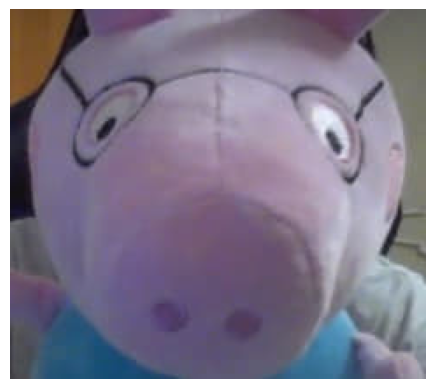


На фото выше не был идентифицирован человек. (Два глаза)



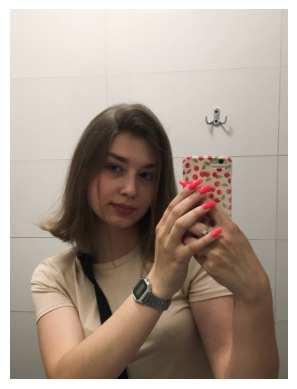

Вероятности людей:

Программа думает что на фото выше liza_dorik


  andrey_bond dina_samatova elvira_lukhmenko kyrrylo_chistik liza_dorik  \
1      0.51 %       16.12 %           1.68 %         34.57 %    46.95 %   

  mykyta_khambur  
1         0.16 %  


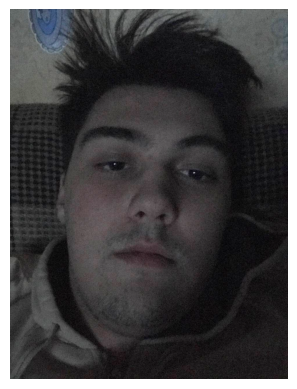


На фото выше не был идентифицирован человек. (Два глаза)



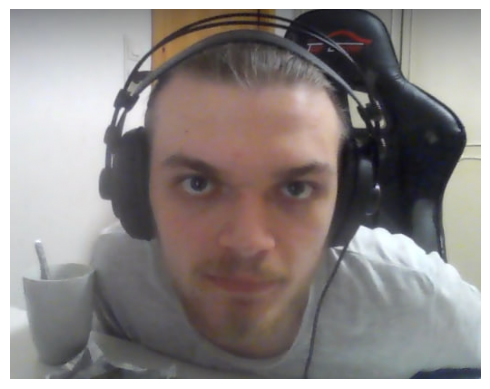

Вероятности людей:

Программа думает что на фото выше mykyta_khambur


  andrey_bond dina_samatova elvira_lukhmenko kyrrylo_chistik liza_dorik  \
1       6.0 %        0.97 %           0.29 %          1.34 %    20.98 %   

  mykyta_khambur  
1        70.42 %  


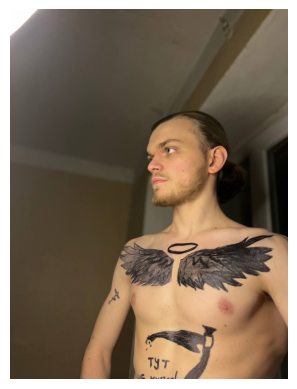


На фото выше не был идентифицирован человек. (Два глаза)



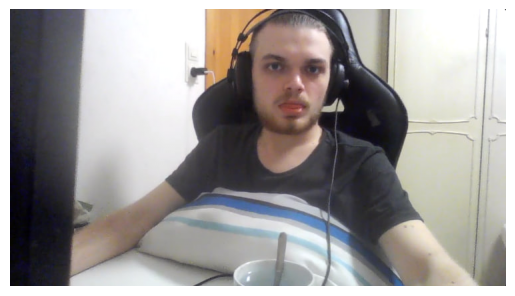

Вероятности людей:

Программа думает что на фото выше mykyta_khambur


  andrey_bond dina_samatova elvira_lukhmenko kyrrylo_chistik liza_dorik  \
1      0.02 %         4.7 %           1.69 %          1.45 %     0.49 %   

  mykyta_khambur  
1        91.65 %  


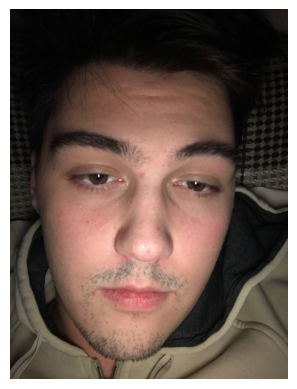

Вероятности людей:

Программа думает что на фото выше andrey_bond


  andrey_bond dina_samatova elvira_lukhmenko kyrrylo_chistik liza_dorik  \
1      37.6 %        0.02 %          36.61 %          6.33 %    18.66 %   

  mykyta_khambur  
1         0.78 %  


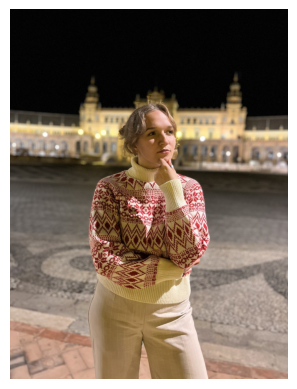

Вероятности людей:

Программа думает что на фото выше dina_samatova


  andrey_bond dina_samatova elvira_lukhmenko kyrrylo_chistik liza_dorik  \
1      0.01 %       32.64 %           0.02 %          32.6 %     2.86 %   

  mykyta_khambur  
1        31.88 %  


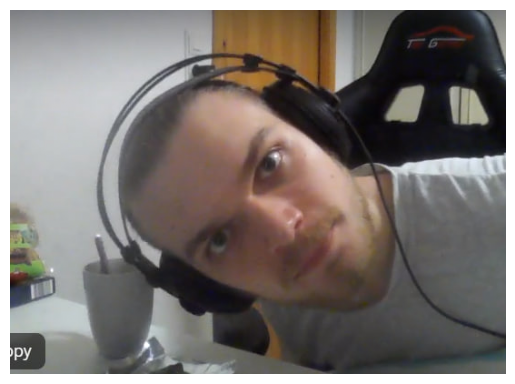


На фото выше не был идентифицирован человек. (Два глаза)



In [22]:
import os

# Переходим в папку с фотографиями
os.chdir(r"C:\Users\spark\PycharmProjects\image_face_recognition\data\test_images")

# Получаем список файлов в папке
file_list = os.listdir()

for file in file_list:
    file_path = r"C:\Users\spark\PycharmProjects\image_face_recognition\data\test_images" + fr"\{file}"
    load_saved_artifacts()

    results = classify_image(file_path, None)

    print_results(results, file_path)